In [2]:
import numpy as np
import pylab as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_prepare(x,y,data_config):
    dataset = []
    labels = []
    selects = []
    for k,v in data_config.items():
        filt = y==k
        assert v<np.sum(filt), 'Requested data is not available, reduce the {} class'.format(k)
        inds = np.argwhere(filt)[:,0]
        np.random.shuffle(inds)
        selceted = inds[:v]
        dataset.extend(x[selceted])
        labels.extend([k]*v)
        selects.extend(selceted)
    return np.delete(x, selects,axis=0),np.delete(y, selects,axis=0),np.array(dataset),np.array(labels)

def describe_labels(y0):
    y = y0+0
    if y.ndim==2:
        y = np.argmax(y,axis=1)
    class_labels, nums = np.unique(y,return_counts=True)
    n_calss = len(class_labels)
    print('labels/numbers are:\n',*['{:5s}/{:6d}\n'.format(str(i),j) for i,j in zip(class_labels,nums)])
    return n_calss

def augment(aug,x):
    aug.fit(x)
    out = []
    for i in x:
        out.append(aug.random_transform(i))
    return np.array(out)

def balance_aug(x0,y0,aug=None,mixup=False):
    x = x0+0
    y = y0+0
    class_labels, nums = np.unique(y,return_counts=True)
    nmax = max(nums)
    for i,(lbl,n0) in enumerate(zip(class_labels,nums)):
        if nmax==n0:
            continue
        delta = nmax-n0
        x_sub = x[y==lbl]
        inds = np.arange(n0)
        nrep = (nmax//len(inds))+1
        inds = np.repeat(inds, nrep)
        np.random.shuffle(inds)
        inds = inds[:delta]
        x_sub = x_sub[inds]
        if not aug is None:
            x_sub = augment(aug,x_sub)
            
        if mixup:
            pass
            
        x = np.concatenate([x,x_sub],axis=0)
        y = np.concatenate([y,delta*[lbl]],axis=0)
    return x,y

class DataFeed:
    def __init__(self,x,y,aug = None):
        self.x = x
        self.y = y
        self.aug = aug
        self.nd,self.nx,self.ny,self.ch = x.shape
        self.banance()
        
    def banance(self):
        self.xb,self.yb = balance_aug(self.x,self.y,aug=self.aug)
        self.ndb = self.xb.shape[0]
    def __call__(self,num,reset=False):
        if reset:
            self.banance()
        inds = np.arange(self.ndb)
        np.random.shuffle(inds)
        inds = inds[:num]
        return self.xb[inds],self.yb[inds]

def rws_score(outliers,v,n_o=None):
    outliers = np.array(outliers)
    if n_o is None:
        n_o = int(np.sum(outliers))
    b_s = np.arange(n_o)+1
    o_ind = np.argsort(v)[::-1]
    o_ind = o_ind[:n_o]
    return 1.*np.sum(b_s*outliers[o_ind].reshape(-1))/np.sum(b_s)

INIT_LR = 1e-3

def lr_scheduler(epoch, lr):
    return lr * 0.985

import numpy as np

class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y
    
def mixup(x0,y0,alpha,beta,num_classes=None):
    x = x0+0
    y = y0+0
    
    tocat = False
    if y.ndim==1:
        y = keras.utils.to_categorical(y,num_classes=num_classes)
        tocat = True
        print('The labels are converted into categorical')

    class_labels, nums = np.unique(y,return_counts=True)
    # print(class_labels, nums)

    
    nums = np.sum(y,axis=0)

    nmax = max(nums)
    # for i,(lbl,n0) in enumerate(zip(class_labels,nums)):
    for i,n0 in enumerate(nums):

        if nmax==n0 or n0==0:
            continue
        delta = int(nmax-n0)
        
        x_sub = x[y[:,i].astype(bool)]
        y_sub = y[y[:,i].astype(bool)]

        inds = np.arange(n0)
        nrep = (nmax//len(inds))
        inds = np.repeat(inds, nrep)
        np.random.shuffle(inds)
        inds = inds[:delta].astype(int)

        x_sub = x_sub[inds]
        y_sub = y_sub[inds]

        b = np.random.beta(alpha,beta,delta)[:,None]

        inds = np.arange(x.shape[0])
        np.random.shuffle(inds)
        inds = inds[:delta]
        xt = x[inds]
        yt = y[inds]

        if x.ndim==2:
            x_sub = b[:,:]*x_sub+(1-b[:,:])*xt
        elif x.ndim==3:
            x_sub = b[:,:,None]*x_sub+(1-b[:,:,None])*xt
        elif x.ndim==4:
            x_sub = b[:,:,None,None]*x_sub+(1-b[:,:,None,None])*xt
        else:
            assert 0,'The shape is not as expected! {}-{}'.format(x.shape,x_sub.shape)
        
        y_sub = b*y_sub+(1-b)*yt

        x = np.concatenate([x,x_sub],axis=0)
        y = np.concatenate([y,y_sub],axis=0)
#     if tocat:
#         y = np.argmax(y,axis=1)
    return x,y


# callbacks = [
#     LearningRateScheduler(lr_scheduler, verbose=1)
# ]
def build_model(shape,n_class,n_latent = 64):
 
    inp = keras.Input(shape=shape, name="input")
    x = layers.Dense(128, activation="relu")(inp)
    latent = layers.Dense(n_latent, activation="relu")(x)
    dop = layers.Dropout(0.6)(latent)
    out = layers.Dense(n_class, activation="softmax")(dop)
    # out = layers.Dense(n_class, activation="sigmoid")(dop)


    clf = keras.Model(inputs=inp, outputs=out, name="Classifier")
    drt = keras.Model(inputs=inp, outputs=latent, name="DimensionalityReducer")

#     clf.summary()

    clf.compile(
    #     loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer='adam',
        metrics=["accuracy"],
    )
    return clf,drt

def iforest_get_anomalies(z):
    isof = IsolationForest()
    isof.fit(z)
    scores_pred = isof.decision_function(z)
    scores_pred = scores_pred.max()-scores_pred
    return scores_pred

report_template = 'iforest RWS on the raw data is mean {:2.2f}, lower {:2.2f}, upper {:2.2f}'

In [3]:
# It shows how beta distribution is:
# plt.hist(np.random.beta(20,1,1000))

In [4]:
aug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.03,
    height_shift_range=0.03,
#     brightness_range=0.01,
#        shear_range=0.0,
    zoom_range=0.03,
#     horizontal_flip=True,
#     vertical_flip=True,
    fill_mode="nearest")

In [4]:
noise = 0.5

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
n_train = len(x_train)

x_train = x_train/255
x_test = x_test/255

x_train += np.random.normal(0,noise,x_train.shape)
x_test += np.random.normal(0,noise,x_test.shape)

x_train = x_train[:,:,:,None]
x_test = x_test[:,:,:,None]

print(x_test.shape, y_test.shape)
data_config = {0:800,1:900,2:3}
x_test, y_test, x_obs1, y_obs1 = data_prepare(x_test,y_test,data_config)
print(x_test.shape, y_test.shape,x_obs1.shape, y_obs1.shape)
print()
print()
print(x_train.shape, y_train.shape)
data_config = {0:4000,1:5000,2:200}
x_train, y_train, x_obs2, y_obs2 = data_prepare(x_train,y_train,data_config)
print(x_train.shape, y_train.shape, x_obs2.shape, y_obs2.shape)
outliers = [2]

(10000, 28, 28, 1) (10000,)
(8297, 28, 28, 1) (8297,) (1703, 28, 28, 1) (1703,)


(60000, 28, 28, 1) (60000,)
(50800, 28, 28, 1) (50800,) (9200, 28, 28, 1) (9200,)


In [5]:
# This shows how augmentation and mixup -upsampling work
# x0 = x_obs1+0
# y0 = y_obs1+0
# n_class = describe_labels(y_obs1)
# x,y = balance_aug(x_obs1,y_obs1,aug)
# n_class = describe_labels(y)

# x0 = x_obs1+0
# y0 = y_obs1+0
# alpha = 20
# beta = 1
# n_class = describe_labels(y_obs1)
# x,y = mixup(x_obs1,y_obs1)
# n_class = describe_labels(y)

In [6]:
# df = DataFeed(x_obs1,y_obs1,aug)

In [7]:
# Take look into several samples
# nx = 20
# ny = 5
# fig,axs = plt.subplots(ny,nx,figsize=(nx,ny+2))
# for i in range(ny):
#     for j in range(nx):
# #         img,lbl = df(1)
#         ir = np.random.randint(x.shape[0])
#         img,lbl = x[ir,:,:,0],np.argmax(y[ir])
#         axs[i,j].imshow(img.reshape(28,28),cmap='gray')
#         axs[i,j].set_title(str(lbl),fontsize=15)
#         axs[i,j].set_axis_off()

In [8]:
inlabels = np.setdiff1d(list(data_config.keys()),outliers)

out1 = np.isin(y_obs1,outliers)
out2 = np.isin(y_obs2,outliers)
# labels = np.logical_not(outlires)

### iforest on the raw data (obs1)

In [9]:
xx = x_obs1.reshape(x_obs1.shape[0],-1)
rwss = []
for _ in range(10):
    scores_pred = iforest_get_anomalies(xx)
    rwss.append(rws_score(out1,scores_pred))
print(report_template.format(np.mean(rwss),
                             np.percentile(rwss,5),
                             np.percentile(rwss,95)))

iforest RWS on the raw data is mean 0.00, lower 0.00, upper 0.00


### iforest on the raw data (obs2)

In [10]:
xx = x_obs2.reshape(x_obs2.shape[0],-1)
rwss = []
for _ in range(10):
    scores_pred = iforest_get_anomalies(xx)
    rwss.append(rws_score(out2,scores_pred))
print(report_template.format(np.mean(rwss),
                             np.percentile(rwss,5),
                             np.percentile(rwss,95)))

iforest RWS on the raw data is mean 0.04, lower 0.02, upper 0.07


### now we train a classifier on obs1

You can use either augmentation or mixup

labels/numbers are:
 0    /   800
 1    /   900
 2    /     3

The labels are converted into categorical
labels/numbers are:
 0    /   900
 1    /   900
 2    /   900



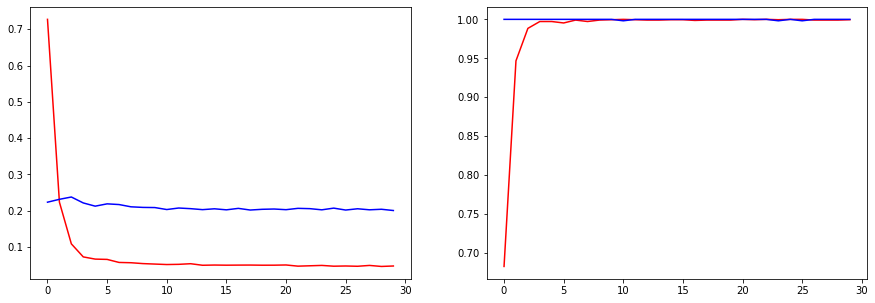

In [11]:
clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)

n_class = describe_labels(y_obs1)
# xx,yy = balance_aug(x_obs1,y_obs1,aug)
xx,yy = mixup(x_obs1,y_obs1,alpha=20,beta=1)
n_class = describe_labels(yy)
xx = xx.reshape(xx.shape[0],-1)
# yy = keras.utils.to_categorical(yy, num_classes=n_class,)

history = clf.fit(xx, yy, batch_size=256, epochs=30, validation_split=0.2,verbose=0)
 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(history.history['loss'],'r')
ax2.plot(history.history['accuracy'],'r')
ax1.plot(history.history['val_loss'],'b')
ax2.plot(history.history['val_accuracy'],'b')

### iforest on the latent space of obs1

In [12]:
xx = x_obs1.reshape(x_obs1.shape[0],-1)
z = drt.predict(xx)
rwss = []
for _ in range(10):
    scores_pred = iforest_get_anomalies(z)
    rwss.append(rws_score(out1,scores_pred))
print(report_template.format(np.mean(rwss),
                             np.percentile(rwss,5),
                             np.percentile(rwss,95)))

iforest RWS on the raw data is mean 1.00, lower 1.00, upper 1.00


### iforest on the latent space of obs2

In [13]:
xx = x_obs2.reshape(x_obs2.shape[0],-1)
z = drt.predict(xx)
rwss = []
for _ in range(10):
    scores_pred = iforest_get_anomalies(z)
    rwss.append(rws_score(out2,scores_pred))
print(report_template.format(np.mean(rwss),
                             np.percentile(rwss,5),
                             np.percentile(rwss,95)))

iforest RWS on the raw data is mean 0.18, lower 0.11, upper 0.24


### or instead of using iforest we can use the third class predicted probability as anomaly score in obs2

In [14]:
xx = x_obs2.reshape(x_obs2.shape[0],-1)
z = clf.predict(xx)

# z = np.argmax(z,axis=1)
# z = np.isin(z,outliers)
z = z[:,n_class-1]

print(rws_score(out2,z))

0.22064676616915424


In [15]:
# confusion_matrix(y_obs2,np.argmax(clf.predict(xx),axis=1))

In [16]:
# n_conf = 5

# # pred = np.round(np.concatenate([z[np.argsort(z)[:n_conf]],z[np.argsort(z)[-n_conf:]]]))
# # truth = np.concatenate([out2[np.argsort(z)[:n_conf]],out2[np.argsort(z)[-n_conf:]]])
# # print('Similarity is {:2.2f}%'.format(np.mean(pred==truth)))
# xx = x_obs2.reshape(x_obs2.shape[0],-1)

# z_clf = clf.predict(xx)
# scr_ano = z_clf[:,n_class-1]
# print(rws_score(out2,scr_ano))

# z_drt = drt.predict(xx)
# scr_ano = iforest_get_anomalies(z_drt)
# print(rws_score(out2,scr_ano))

### we also can use normal/anomaly as labels instead of the real labels

labels/numbers are:
 0    /   800
 1    /   900
 2    /     3

labels/numbers are:
 0    /  1700
 1    /  1700



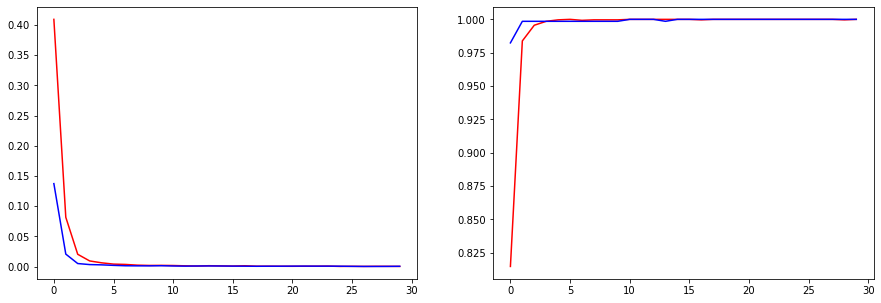

In [17]:
clf,drt = build_model(shape=(28*28),n_class=2,n_latent = 64)

n_class = describe_labels(y_obs1)
xx,yy = balance_aug(x_obs1,out1,aug)
n_class = describe_labels(yy)

xx = xx.reshape(xx.shape[0],-1)
yy = keras.utils.to_categorical(yy)

history = clf.fit(xx, yy, batch_size=256, epochs=30, validation_split=0.2,verbose=0)
 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(history.history['loss'],'r')
ax2.plot(history.history['accuracy'],'r')
ax1.plot(history.history['val_loss'],'b')
ax2.plot(history.history['val_accuracy'],'b')

In [18]:
xx = x_obs2.reshape(x_obs2.shape[0],-1)
z = clf.predict(xx)
z = z[:,n_class-1]
print(rws_score(out2,z))

0.48771144278606965


In [19]:
# confusion_matrix(out2,np.argmax(clf.predict(xx),axis=1))

the old version of human in the loop:

In [20]:
# n_conf = 5

# pred = np.round(np.concatenate([z[np.argsort(z)[:n_conf]],z[np.argsort(z)[-n_conf:]]]))
# truth = np.concatenate([out2[np.argsort(z)[:n_conf]],out2[np.argsort(z)[-n_conf:]]])
# print('Similarity is {:2.2f}%'.format(np.mean(pred==truth)))

# x1 = x_obs2[np.argsort(z)[:n_conf]]
# x2 = x_obs2[np.argsort(z)[-n_conf:]]
# x_new = np.concatenate([x1,x2],axis=0)
# y_new = np.array(n_conf*[0]+n_conf*[1])
# x_new = np.concatenate([x_obs1,x_new],axis=0)
# y_new = np.concatenate([out1,y_new],axis=0)
# n_class = describe_labels(y_new)
# xx,yy = balance_aug(x_new,y_new,aug)
# n_class = describe_labels(yy)



In [21]:
# xx = xx.reshape(xx.shape[0],-1)
# yy = keras.utils.to_categorical(yy)

# history = clf.fit(xx, yy, batch_size=256, epochs=30, validation_split=0.2,verbose=0)
 
# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# ax1.plot(history.history['loss'],'r')
# ax2.plot(history.history['accuracy'],'r')
# ax1.plot(history.history['val_loss'],'b')
# ax2.plot(history.history['val_accuracy'],'b')

In [22]:
# xx = x_obs2.reshape(x_obs2.shape[0],-1)
# z = clf.predict(xx)
# z = z[:,n_class-1]
# print(rws_score(out2,z))

In [23]:
# n_conf = 5

# pred = np.round(np.concatenate([z[np.argsort(z)[:n_conf]],z[np.argsort(z)[-n_conf:]]]))
# truth = np.concatenate([out2[np.argsort(z)[:n_conf]],out2[np.argsort(z)[-n_conf:]]])
# print('Similarity is {:2.2f}%'.format(np.mean(pred==truth)))

# x_old,y_old = x_new+0,y_new+0
# x1 = x_obs2[np.argsort(z)[:n_conf]]
# x2 = x_obs2[np.argsort(z)[-n_conf:]]
# x_new = np.concatenate([x1,x2],axis=0)
# y_new = np.array(n_conf*[0]+n_conf*[1])
# x_new = np.concatenate([x_old,x_new],axis=0)
# y_new = np.concatenate([y_old,y_new],axis=0)
# n_class = describe_labels(y_new)
# xx,yy = balance_aug(x_new,y_new,aug)
# n_class = describe_labels(yy)

# xx = xx.reshape(xx.shape[0],-1)
# yy = keras.utils.to_categorical(yy)

# history = clf.fit(xx, yy, batch_size=256, epochs=30, validation_split=0.2,verbose=0)
 
# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# ax1.plot(history.history['loss'],'r')
# ax2.plot(history.history['accuracy'],'r')
# ax1.plot(history.history['val_loss'],'b')
# ax2.plot(history.history['val_accuracy'],'b')

In [24]:
# xx = x_obs2.reshape(x_obs2.shape[0],-1)
# z = clf.predict(xx)
# z = z[:,n_class-1]
# print(rws_score(out2,z))

# Human in the loop (version 2)

### Data prep

In [25]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
n_train = len(x_train)

print(x_test.shape, y_test.shape)
data_config = {0:800,1:900,2:0}

x_test, y_test, x_obs1, y_obs1 = data_prepare(x_test,y_test,data_config)
print(x_test.shape, y_test.shape,x_obs1.shape, y_obs1.shape)
print()
print()
print(x_train.shape, y_train.shape)
data_config = {0:4000,1:5000,2:200}
x_train, y_train, x_obs2, y_obs2 = data_prepare(x_train,y_train,data_config)
print(x_train.shape, y_train.shape, x_obs2.shape, y_obs2.shape)
x_obs1 = x_obs1[:,:,:,None]
x_obs2 = x_obs2[:,:,:,None]

noise = 0.1

x_obs1 = x_obs1/255
x_obs2 = x_obs2/255
x_obs1 += np.random.normal(0,noise,x_obs1.shape)
x_obs2 += np.random.normal(0,noise,x_obs2.shape)
outliers = [2]

n_class = describe_labels(y_obs1)
n_class = describe_labels(y_obs2)

(10000, 28, 28) (10000,)
(8300, 28, 28) (8300,) (1700, 28, 28) (1700,)


(60000, 28, 28) (60000,)
(50800, 28, 28) (50800,) (9200, 28, 28) (9200,)
labels/numbers are:
 0    /   800
 1    /   900

labels/numbers are:
 0    /  4000
 1    /  5000
 2    /   200



# if model keep training

### augmentation

In [26]:
epochs = 2

Text(0, 0.5, 'Human added on top 10')

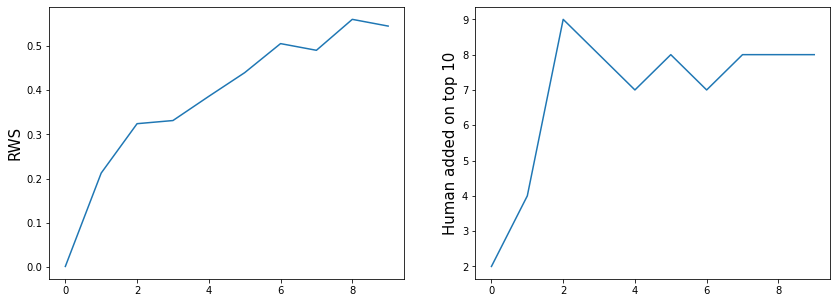

In [27]:
clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)

n_conf = 10
x_obs1p = x_obs1.reshape(x_obs1.shape[0],-1)
y_obs1p = y_obs1+0
x_obs2p = x_obs2.reshape(x_obs2.shape[0],-1)
y_obs2p = y_obs2+0

rwss = []
true_guess = []

for _ in range(10):
    x_obs1p = x_obs1p.reshape(-1,28,28,1)
    xx,yy = balance_aug(x_obs1p,y_obs1p,aug)
    x_obs1p = x_obs1p.reshape(-1,784)
    xx = xx.reshape(-1,784)
    yy = keras.utils.to_categorical(yy, num_classes=n_class,)
    history = clf.fit(xx, yy, batch_size=256, epochs=epochs, validation_split=0.2,verbose=0)
    acc = history.history['accuracy'][-1]

    out2 = np.isin(y_obs2p,outliers)
    z_clf = clf.predict(x_obs2p)
    scr_ano = z_clf[:,n_class-1]
    rws = rws_score(out2,scr_ano)

#     print('acc:{:2.2f}, rws:{:2.2f}'.format(acc,rws))
    rwss.append(rws)

    # This is where the human act
    inds = np.intersect1d(np.argsort(scr_ano)[-n_conf:],np.argwhere(out2)[:,0])
    true_guess.append(len(inds))
    x_obs1p = np.concatenate([x_obs2p[inds],x_obs1p],axis=0)
    y_obs1p = np.concatenate([y_obs2p[inds],y_obs1p],axis=0)

    x_obs2p = np.delete(x_obs2p,inds,axis=0)
    y_obs2p = np.delete(y_obs2p,inds,axis=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(rwss)
ax1.set_ylabel('RWS',fontsize=15)
ax2.plot(true_guess)
ax2.set_ylabel('Human added on top 10',fontsize=15)

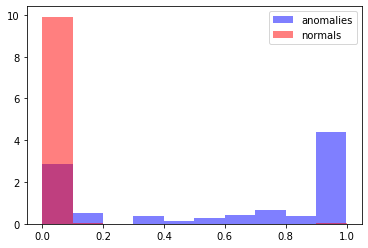

In [28]:
plt.hist(scr_ano[out2],color='b',alpha=0.5,label='anomalies',density=True)
plt.hist(scr_ano[~out2],color='r',alpha=0.5,label='normals',density=True)
plt.legend()

### mixup

The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical


Text(0, 0.5, 'Human added on top 10')

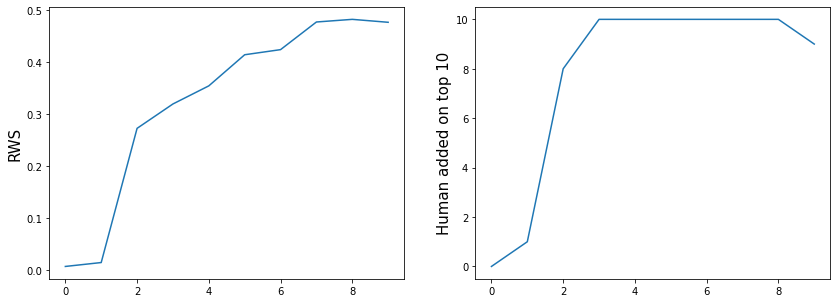

In [29]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
# n_train = len(x_train)

# print(x_test.shape, y_test.shape)
# data_config = {0:800,1:900,2:0}

# x_test, y_test, x_obs1, y_obs1 = data_prepare(x_test,y_test,data_config)
# print(x_test.shape, y_test.shape,x_obs1.shape, y_obs1.shape)
# print()
# print()
# print(x_train.shape, y_train.shape)
# data_config = {0:4000,1:5000,2:200}
# x_train, y_train, x_obs2, y_obs2 = data_prepare(x_train,y_train,data_config)
# print(x_train.shape, y_train.shape, x_obs2.shape, y_obs2.shape)
# x_obs1 = x_obs1[:,:,:,None]
# x_obs2 = x_obs2[:,:,:,None]

# noise = 0.1

# x_obs1 = x_obs1/255
# x_obs2 = x_obs2/255
# x_obs1 += np.random.normal(0,noise,x_obs1.shape)
# x_obs2 += np.random.normal(0,noise,x_obs2.shape)
# outliers = [2]

# n_class = describe_labels(y_obs1)
# n_class = describe_labels(y_obs2)

clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)

n_conf = 10
x_obs1p = x_obs1.reshape(x_obs1.shape[0],-1)
y_obs1p = y_obs1+0
x_obs2p = x_obs2.reshape(x_obs2.shape[0],-1)
y_obs2p = y_obs2+0

rwss = []
true_guess = []

for _ in range(10):
    xx,yy = mixup(x_obs1p,y_obs1p,alpha=5,beta=1,num_classes=n_class)
    history = clf.fit(xx, yy, batch_size=256, epochs=epochs, validation_split=0.2,verbose=0)
    acc = history.history['accuracy'][-1]

    out2 = np.isin(y_obs2p,outliers)
    z_clf = clf.predict(x_obs2p)
    scr_ano = z_clf[:,n_class-1]
    rws = rws_score(out2,scr_ano)
    rwss.append(rws)

    # This is where the human act
    inds = np.intersect1d(np.argsort(scr_ano)[-n_conf:],np.argwhere(out2)[:,0])
    true_guess.append(len(inds))
    x_obs1p = np.concatenate([x_obs2p[inds],x_obs1p],axis=0)
    y_obs1p = np.concatenate([y_obs2p[inds],y_obs1p],axis=0)

    x_obs2p = np.delete(x_obs2p,inds,axis=0)
    y_obs2p = np.delete(y_obs2p,inds,axis=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(rwss)
ax1.set_ylabel('RWS',fontsize=15)
ax2.plot(true_guess)
ax2.set_ylabel('Human added on top 10',fontsize=15)

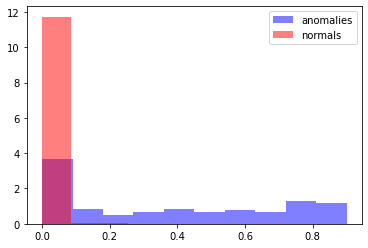

In [30]:
plt.hist(scr_ano[out2],color='b',alpha=0.5,label='anomalies',density=True)
plt.hist(scr_ano[~out2],color='r',alpha=0.5,label='normals',density=True)
plt.legend()

# if model resets everytime

### augmentation

Text(0, 0.5, 'Human added on top 10')

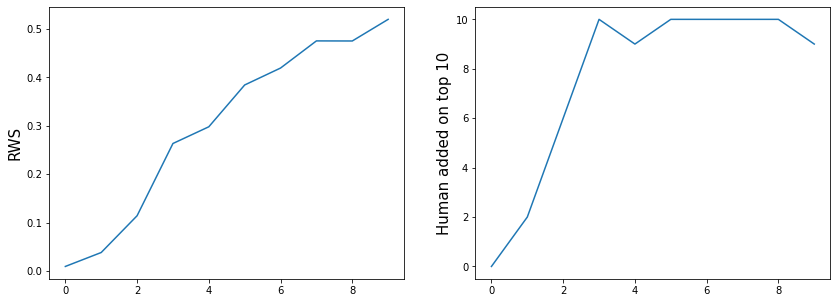

In [31]:
n_conf = 10
x_obs1p = x_obs1.reshape(x_obs1.shape[0],-1)
y_obs1p = y_obs1+0
x_obs2p = x_obs2.reshape(x_obs2.shape[0],-1)
y_obs2p = y_obs2+0

rwss = []
true_guess = []

for _ in range(10):
    x_obs1p = x_obs1p.reshape(-1,28,28,1)
    xx,yy = balance_aug(x_obs1p,y_obs1p,aug)
    x_obs1p = x_obs1p.reshape(-1,784)
    xx = xx.reshape(-1,784)
    yy = keras.utils.to_categorical(yy, num_classes=n_class,)
    clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)
    history = clf.fit(xx, yy, batch_size=256, epochs=epochs, validation_split=0.2,verbose=0)
    acc = history.history['accuracy'][-1]

    out2 = np.isin(y_obs2p,outliers)
    z_clf = clf.predict(x_obs2p)
    scr_ano = z_clf[:,n_class-1]
    rws = rws_score(out2,scr_ano)

#     print('acc:{:2.2f}, rws:{:2.2f}'.format(acc,rws))
    rwss.append(rws)

    # This is where the human act
    inds = np.intersect1d(np.argsort(scr_ano)[-n_conf:],np.argwhere(out2)[:,0])
    true_guess.append(len(inds))
    x_obs1p = np.concatenate([x_obs2p[inds],x_obs1p],axis=0)
    y_obs1p = np.concatenate([y_obs2p[inds],y_obs1p],axis=0)

    x_obs2p = np.delete(x_obs2p,inds,axis=0)
    y_obs2p = np.delete(y_obs2p,inds,axis=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(rwss)
ax1.set_ylabel('RWS',fontsize=15)
ax2.plot(true_guess)
ax2.set_ylabel('Human added on top 10',fontsize=15)

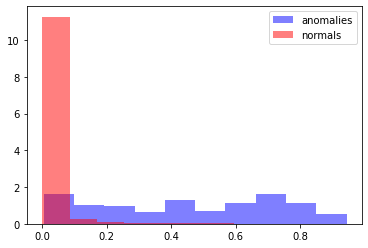

In [32]:
plt.hist(scr_ano[out2],color='b',alpha=0.5,label='anomalies',density=True)
plt.hist(scr_ano[~out2],color='r',alpha=0.5,label='normals',density=True)
plt.legend()

### mixup

The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical
The labels are converted into categorical


Text(0, 0.5, 'Human added on top 10')

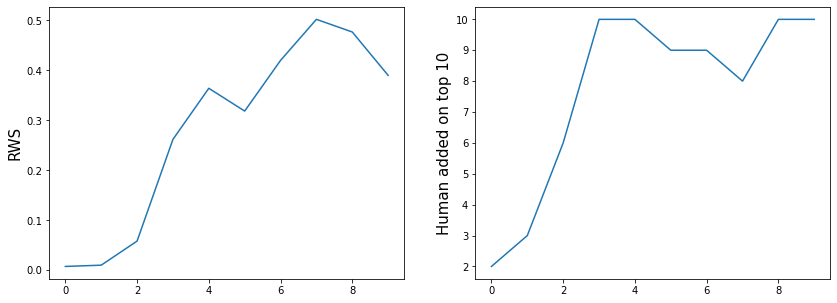

In [33]:
n_conf = 10
x_obs1p = x_obs1.reshape(x_obs1.shape[0],-1)
y_obs1p = y_obs1+0
x_obs2p = x_obs2.reshape(x_obs2.shape[0],-1)
y_obs2p = y_obs2+0

rwss = []
true_guess = []

for _ in range(10):
    xx,yy = mixup(x_obs1p,y_obs1p,alpha=5,beta=1,num_classes=n_class)
    clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)
    history = clf.fit(xx, yy, batch_size=256, epochs=epochs, validation_split=0.2,verbose=0)
    acc = history.history['accuracy'][-1]

    out2 = np.isin(y_obs2p,outliers)
    z_clf = clf.predict(x_obs2p)
    scr_ano = z_clf[:,n_class-1]
    rws = rws_score(out2,scr_ano)
    rwss.append(rws)

    # This is where the human act
    inds = np.intersect1d(np.argsort(scr_ano)[-n_conf:],np.argwhere(out2)[:,0])
    true_guess.append(len(inds))
    x_obs1p = np.concatenate([x_obs2p[inds],x_obs1p],axis=0)
    y_obs1p = np.concatenate([y_obs2p[inds],y_obs1p],axis=0)

    x_obs2p = np.delete(x_obs2p,inds,axis=0)
    y_obs2p = np.delete(y_obs2p,inds,axis=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(rwss)
ax1.set_ylabel('RWS',fontsize=15)
ax2.plot(true_guess)
ax2.set_ylabel('Human added on top 10',fontsize=15)

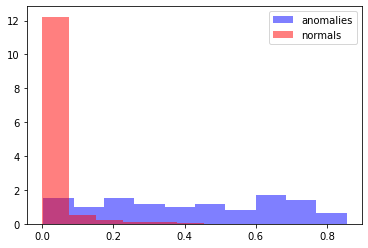

In [34]:
plt.hist(scr_ano[out2],color='b',alpha=0.5,label='anomalies',density=True)
plt.hist(scr_ano[~out2],color='r',alpha=0.5,label='normals',density=True)
plt.legend()

### stream of observation

In [10]:
class Observetory:
    def __init__(self,plan,x,y):
        self.plan = plan
        self.x = x
        self.y = y
        self.x_obs = np.zeros( [0]+list(self.x.shape[1:]) )
        self.y_obs = np.zeros( [0]+list(self.y.shape[1:]) )
        self.num_obs = 0
        self.n_plan = len(self.plan)
#         self.new_obs()
    def new_obs(self,safemode=False):
        if self.num_obs==self.n_plan:
            if safemode:
                print('out of plan!')
                return self.x_obs,self.y_obs
            else:
                assert 0,'No more plan!' 
        data_config = plan[self.num_obs]
        self.x,self.y, x_obs, y_obs = data_prepare(self.x,self.y,data_config)
        self.x_obs = np.concatenate([self.x_obs,x_obs],axis=0)
        self.y_obs = np.concatenate([self.y_obs,y_obs],axis=0)
#         print(self.x_obs.shape, self.y_obs.shape, self.x.shape, self.y.shape)
        self.num_obs += 1
        return self.x_obs,self.y_obs
    def delete(self,inds):
        self.x_obs = np.delete(self.x_obs,inds,axis=0)
        self.y_obs = np.delete(self.y_obs,inds,axis=0)

noise = 0.1
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
n_train = len(x_train)
x_train = x_train/255
x_test = x_test/255
x_train += np.random.normal(0,noise,x_train.shape)
x_test += np.random.normal(0,noise,x_test.shape)
x_train = x_train[:,:,:,None]
x_test = x_test[:,:,:,None]

data_config = {0:800,1:900,2:0}
plan = 3*[{0:350,1:400,2:15}]
outliers = [2]

print(' ******** Our first dataset ******** ')

x_test, y_test, x_obs1, y_obs1 = data_prepare(x_test,y_test,data_config)
n_class = describe_labels(y_obs1)

print(' ******** Observation begins ******** ')
obs = Observetory(plan,x_train,y_train)
x_obs2,y_obs2 = obs.new_obs()
n_class = describe_labels(y_obs2)

for _ in range(obs.n_plan+1):
    x_obs,y_obs = obs.new_obs(safemode=1)
    n_class = describe_labels(y_obs)

 ******** Our first dataset ******** 
labels/numbers are:
 0    /   800
 1    /   900

 ******** Observation begins ******** 
labels/numbers are:
 0.0  /   350
 1.0  /   400
 2.0  /    15

labels/numbers are:
 0.0  /   700
 1.0  /   800
 2.0  /    30

labels/numbers are:
 0.0  /  1050
 1.0  /  1200
 2.0  /    45

out of plan!
labels/numbers are:
 0.0  /  1050
 1.0  /  1200
 2.0  /    45

out of plan!
labels/numbers are:
 0.0  /  1050
 1.0  /  1200
 2.0  /    45



In [11]:
epochs = 5
noise = 0.1
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
n_train = len(x_train)
x_train = x_train/255
x_test = x_test/255
x_train += np.random.normal(0,noise,x_train.shape)
x_test += np.random.normal(0,noise,x_test.shape)
x_train = x_train[:,:,:,None]
x_test = x_test[:,:,:,None]

clf,drt = build_model(shape=(28*28),n_class=3,n_latent = 64)

n_conf = 5

data_config = {0:800,1:900,2:0}
plan = 20*[{0:170,1:200,2:7}]
outliers = [2]

print(' ******** Our first dataset ******** ')

x_test, y_test, x_obs1, y_obs1 = data_prepare(x_test,y_test,data_config)
n_class = describe_labels(y_obs1)
x_obs1p = x_obs1.reshape(x_obs1.shape[0],-1)
y_obs1p = y_obs1+0

print(' ******** Observation begins ******** ')
obs = Observetory(plan,x_train,y_train)

rws_nn = []
rws_if1 = []
rws_if2 = []
true_guess = []
ress = []

for _ in range(obs.n_plan+10):
    x_obs2,y_obs2 = obs.new_obs(safemode=1)
    print('NEW OBS:')
    n_class = describe_labels(y_obs2)

    x_obs2p = x_obs2.reshape(x_obs2.shape[0],-1)
    y_obs2p = y_obs2+0
    out2 = np.isin(y_obs2p,outliers)
    
    isof = IsolationForest()
    isof.fit(x_obs1.reshape(-1,784))
    s1 = isof.decision_function(x_obs2p.reshape(-1,784))
    s1 = s1.max()-s1
    rws = rws_score(out2,s1)
    rws_if1.append(rws)
   
    isof = IsolationForest()
    isof.fit(x_obs2p.reshape(-1,784))
    s2 = isof.decision_function(x_obs2p.reshape(-1,784))
    s2 = s2.max()-s2
    rws = rws_score(out2,s2)
    rws_if2.append(rws)

    x_obs1p = x_obs1p.reshape(-1,28,28,1)
    xx,yy = balance_aug(x_obs1p,y_obs1p,aug)
    x_obs1p = x_obs1p.reshape(-1,784)
    xx = xx.reshape(-1,784)
    yy = keras.utils.to_categorical(yy, num_classes=n_class,)
    history = clf.fit(xx, yy, batch_size=256, epochs=epochs, validation_split=0.2,verbose=0)
#     acc = history.history['accuracy'][-1]

    z_clf = clf.predict(x_obs2p)
    scr_ano = z_clf[:,n_class-1]
    rws = rws_score(out2,scr_ano)

#     print('acc:{:2.2f}, rws:{:2.2f}'.format(acc,rws))
    rws_nn.append(rws)

    # This is where the human act
    inds = np.intersect1d(np.argsort(scr_ano)[-n_conf:],np.argwhere(out2)[:,0])
    true_guess.append(len(inds))
    x_obs1p = np.concatenate([x_obs2p[inds],x_obs1p],axis=0)
    y_obs1p = np.concatenate([y_obs2p[inds],y_obs1p],axis=0)
    
    print('HUMAN: {} new outliers are detected!'.format(len(inds)))
    print('DATASET is extended to:')
    describe_labels(y_obs1p)
    ress.append([out2,s1,s2,scr_ano])
#     print(y_obs1p)

#     x_obs2p = np.delete(x_obs2p,inds,axis=0)
#     y_obs2p = np.delete(y_obs2p,inds,axis=0)
    obs.delete(inds)

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
# ax1.plot(rwss)
# ax1.set_ylabel('RWS',fontsize=15)
# ax2.plot(true_guess)
# ax2.set_ylabel('Human added on top 10',fontsize=15)

 ******** Our first dataset ******** 
labels/numbers are:
 0    /   800
 1    /   900

 ******** Observation begins ******** 
NEW OBS:
labels/numbers are:
 0.0  /   170
 1.0  /   200
 2.0  /     7

HUMAN: 1 new outliers are detected!
DATASET is extended to:
labels/numbers are:
 0.0  /   800
 1.0  /   900
 2.0  /     1

NEW OBS:
labels/numbers are:
 0.0  /   340
 1.0  /   400
 2.0  /    13

HUMAN: 3 new outliers are detected!
DATASET is extended to:
labels/numbers are:
 0.0  /   800
 1.0  /   900
 2.0  /     4

NEW OBS:
labels/numbers are:
 0.0  /   510
 1.0  /   600
 2.0  /    17

HUMAN: 4 new outliers are detected!
DATASET is extended to:
labels/numbers are:
 0.0  /   800
 1.0  /   900
 2.0  /     8

NEW OBS:
labels/numbers are:
 0.0  /   680
 1.0  /   800
 2.0  /    20

HUMAN: 4 new outliers are detected!
DATASET is extended to:
labels/numbers are:
 0.0  /   800
 1.0  /   900
 2.0  /    12

NEW OBS:
labels/numbers are:
 0.0  /   850
 1.0  /  1000
 2.0  /    23

HUMAN: 4 new outliers 

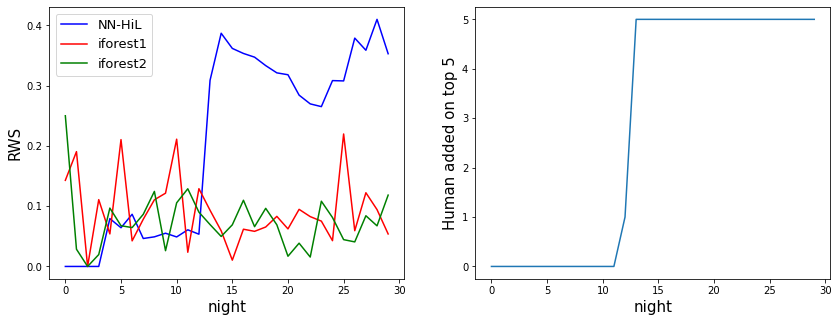

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot(rws_nn,'b',label='NN-HiL')
ax1.plot(rws_if1,'r',label='iforest1')
ax1.plot(rws_if2,'g',label='iforest2')
ax1.set_xlabel('night',fontsize=15)
ax1.set_ylabel('RWS',fontsize=15)
ax2.plot(true_guess)
ax2.set_xlabel('night',fontsize=15)
ax2.set_ylabel('Human added on top {}'.format(n_conf),fontsize=15)
ax1.legend(fontsize=13)
plt.savefig('result.jpg',dpi=150)

# You are entering the under-construction zone!

In [ ]:
x_train = x_train.reshape(-1, 784).astype("float32") / 255


inputs = keras.Input(shape=(784,))
# Just for demonstration purposes.

inp = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(inp)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

clf = keras.Model(encoder_input, encoder_output, name="encoder")
clf.summary()






model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])


In [ ]:
inputs = keras.Input(shape=(784,))
# Just for demonstration purposes.



inp = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(inp)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()
